<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description-of-the-project" data-toc-modified-id="Description-of-the-project-1">Description of the project</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1">Introduction</a></span></li><li><span><a href="#Plan" data-toc-modified-id="Plan-1.2">Plan</a></span></li></ul></li><li><span><a href="#1-Data-exploration" data-toc-modified-id="1-Data-exploration-2">1 Data exploration</a></span><ul class="toc-item"><li><span><a href="#Categorical-features" data-toc-modified-id="Categorical-features-2.1">Categorical features</a></span></li><li><span><a href="#Numerical-features" data-toc-modified-id="Numerical-features-2.2">Numerical features</a></span></li></ul></li><li><span><a href="#2-Data-preprocessing" data-toc-modified-id="2-Data-preprocessing-3">2 Data preprocessing</a></span></li><li><span><a href="#3-Model-training" data-toc-modified-id="3-Model-training-4">3 Model training</a></span><ul class="toc-item"><li><span><a href="#Imbalance" data-toc-modified-id="Imbalance-4.1">Imbalance</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-4.2">Modelling</a></span><ul class="toc-item"><li><span><a href="#LGBM" data-toc-modified-id="LGBM-4.2.1">LGBM</a></span></li><li><span><a href="#RF" data-toc-modified-id="RF-4.2.2">RF</a></span></li></ul></li><li><span><a href="#Tune-ensemble-weights" data-toc-modified-id="Tune-ensemble-weights-4.3">Tune ensemble weights</a></span></li><li><span><a href="#Get-results-on-test" data-toc-modified-id="Get-results-on-test-4.4">Get results on test</a></span></li></ul></li><li><span><a href="#4-Summary" data-toc-modified-id="4-Summary-5">4 Summary</a></span></li></ul></div>

# Description of the project

## Introduction

In this project, we work with the dataset based on the census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau. Our goal is to predict level of income of a person: "- 50000" (means less than \$50k/year)  or "50000+" (means more than \$50k/year). 

The description of the data is available here: https://archive.ics.uci.edu/ml/datasets/Census-Income+%28KDD%29

_Citation:_

* _Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

## Plan
So, what is going to be done during the project?<br>
  - First of all, we are going to explore features, get some business insights from the exploration and help ourselves to develop preprocessing strategy.<br>
  - Secondly, we are going to create preprocessing pipeline based on the information about the features that we got earlier.<br>
  - Then we are going to try imbalance avoid technique.<br>
  - After that comes modelling. We are going to do some grid search for a gradient boosting model and a random forest. For the fitted models we will create very simple stack. <br>
  - Finally, we are going to explore feature importance and describe the results. 

In [1]:
%load_ext autoreload
%autoreload 2

import helper as hlp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from pandas_profiling import ProfileReport
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

from lightgbm import LGBMClassifier, plot_importance

%matplotlib inline
sns.set()

from sklearn import set_config
set_config(display='diagram')

# 1 Data exploration

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,target
0,30,Self-employed-incorporated,39,32,High school graduate,0,Not in universe,Divorced,Personal services except private HH,Other service,...,Not in universe,Greece,England,United-States,Native- Born in the United States,0,Not in universe,2,52,- 50000.
1,7,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,0,0,- 50000.
2,26,Private,2,44,11th grade,0,Not in universe,Never married,Agriculture,Farming forestry and fishing,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,- 50000.
3,47,Private,45,23,Some college but no degree,0,Not in universe,Married-civilian spouse present,Other professional services,Adm support including clerical,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,- 50000.
4,29,Private,4,23,High school graduate,0,Not in universe,Married-civilian spouse present,Construction,Adm support including clerical,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,- 50000.


In [4]:
# Features types.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AAGE      20000 non-null  int64 
 1   ACLSWKR   20000 non-null  object
 2   ADTIND    20000 non-null  int64 
 3   ADTOCC    20000 non-null  int64 
 4   AHGA      20000 non-null  object
 5   AHRSPAY   20000 non-null  int64 
 6   AHSCOL    20000 non-null  object
 7   AMARITL   20000 non-null  object
 8   AMJIND    20000 non-null  object
 9   AMJOCC    20000 non-null  object
 10  ARACE     20000 non-null  object
 11  AREORGN   20000 non-null  object
 12  ASEX      20000 non-null  object
 13  AUNMEM    20000 non-null  object
 14  AUNTYPE   20000 non-null  object
 15  AWKSTAT   20000 non-null  object
 16  CAPGAIN   20000 non-null  int64 
 17  CAPLOSS   20000 non-null  int64 
 18  DIVVAL    20000 non-null  int64 
 19  FILESTAT  20000 non-null  object
 20  GRINREG   20000 non-null  object
 21  GRINST    20

We can see that we have either integer or categorical features. Let's devide them into 2 lists for feature convenience.

In [5]:
# Devide features into numerical and categorical.
cat_fs = []
num_fs = []
for feature, f_type in train.dtypes.to_dict().items():
    if feature != 'target':
        if f_type == 'object':
            cat_fs.append(feature)
        else:
            num_fs.append(feature)

In [6]:
# Basic statistics for numerical features.
train.describe()

,AAGE,ADTIND,ADTOCC,AHRSPAY,CAPGAIN,CAPLOSS,DIVVAL,NOEMP,SEOTR,VETYN,WKSWORK
count,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.00000,20000.000000
mean,34.311650,15.06725,11.198000,57.491600,446.020700,38.419400,190.14890,1.937100,0.169550,1.51040,22.936100
std,22.282696,17.95761,14.423228,291.888256,4653.231295,274.692375,1888.16004,2.362165,0.546276,0.85389,24.415192
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
25%,15.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.75000,0.000000
50%,33.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,2.00000,6.000000
75%,50.000000,33.00000,26.000000,0.000000,0.000000,0.000000,0.00000,4.000000,0.000000,2.00000,52.000000
max,90.000000,51.00000,46.000000,9916.000000,99999.000000,4356.000000,99999.00000,6.000000,2.000000,2.00000,52.000000


In [7]:
# Strip whitespaces from categotical columns
for col in cat_fs:
    train[col] = train[col].str.strip()
    test[col] = test[col].str.strip()

In [8]:
# Devide data into features and target.
Y = train['target'].copy()
X = train.drop('target', axis=1).copy()
del train

In [9]:
# Devide data into train, validation and test
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

print(f'Train size: {X_train.shape[0]} \nValidation size: {X_val.shape[0]} \nTest size: {test.shape[0]}')

Train size: 16000 
Validation size: 4000 
Test size: 10000


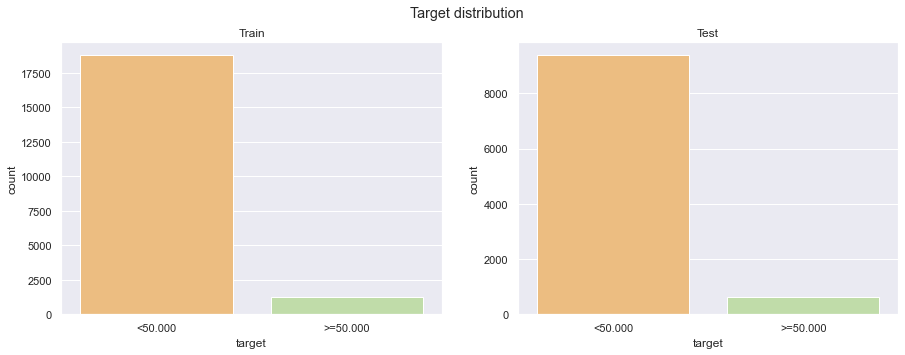

In [10]:
# Plot target distribution.
fig, ax = plt.subplots(figsize=(15, 5), ncols=2, nrows=1, sharex=True)

sns.countplot(x=Y, palette='Spectral', ax=ax[0])
ax[0].set_xticklabels(['<50.000', '>=50.000'])
ax[0].set_title('Train')

sns.countplot(x=test['target'], palette='Spectral', ax=ax[1])
ax[1].set_xticklabels(['<50.000', '>=50.000'])
ax[1].set_title('Test')

plt.suptitle('Target distribution')
plt.show()

We can see that the target is highly imbalanced. Which is why we need stratification during splitting data into train and validation and during the validation process itself. <br> Besides, let's think about metrics in advance also. For our task we want to correctly predict both, TN and TP, so we need some metric that also considers TN(not all of them do). So we can choose simple balanced accuracy and MCC to check for qualities of the models. Balanced accuracy is just a mean on precision of both classes. MCC is a difference between geometric means of precision and recall of both classes. <br> Finally, we will plot classification report for better understanding model results .<br>
Also we are going to try some imbalance preventing techniques during preprocessing and training. 

## Categorical features

In [11]:
X[cat_fs].head(3)

,ACLSWKR,AHGA,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,...,MIGMTR3,MIGMTR4,MIGSAME,MIGSUN,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,VETQVA
0,Self-employed-incorporated,High school graduate,Not in universe,Divorced,Personal services except private HH,Other service,White,All other,Female,Not in universe,...,Different state same division,Different state in South,No,No,Not in universe,Greece,England,United-States,Native- Born in the United States,Not in universe
1,Not in universe,Children,Not in universe,Never married,Not in universe or children,Not in universe,White,Mexican (Mexicano),Male,Not in universe,...,Nonmover,Nonmover,Yes,Not in universe,Both parents present,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,Not in universe
2,Private,11th grade,Not in universe,Never married,Agriculture,Farming forestry and fishing,White,All other,Male,Not in universe,...,Nonmover,Nonmover,Yes,Not in universe,Not in universe,United-States,United-States,United-States,Native- Born in the United States,Not in universe


There are no None values in the datset, however we can see '?' which we assume equals the same. There is also 'Not in universe' value, which means that some particular feature can't be considered for the observed person.

In [12]:
X[cat_fs].replace({'?' : None}).isna().sum() / X[cat_fs].shape[0]*100

ACLSWKR      0.000
AHGA         0.000
AHSCOL       0.000
AMARITL      0.000
AMJIND       0.000
AMJOCC       0.000
ARACE        0.000
AREORGN      0.000
ASEX         0.000
AUNMEM       0.000
AUNTYPE      0.000
AWKSTAT      0.000
FILESTAT     0.000
GRINREG      0.000
GRINST       0.370
HHDFMX       0.000
HHDREL       0.000
MIGMTR1     50.180
MIGMTR3     50.180
MIGMTR4     50.180
MIGSAME      0.000
MIGSUN      50.180
PARENT       0.000
PEFNTVTY     3.235
PEMNTVTY     3.065
PENATVTY     1.705
PRCITSHP     0.000
VETQVA       0.000
dtype: float64

Features with about 50% of missing values can't be properly preprocessed, an attempt to fill in the missing values will generate ambiguity, so we are going to drop these columns.

In [13]:
cols_to_remove = ['MIGMTR1', 'MIGMTR3', 'MIGMTR4']
hlp.remove_features(cols_to_remove, [X_train, X_val, test])
for col in cols_to_remove:
    cat_fs.remove(col)

C:\Anaconda3\envs\ds37\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


For the rest of the columns with empty values the empty value sratio is quite low, so we can just use simple mean imputing technic.

Now, let's take a look on the categorical features distribution to define best encoding strategies.

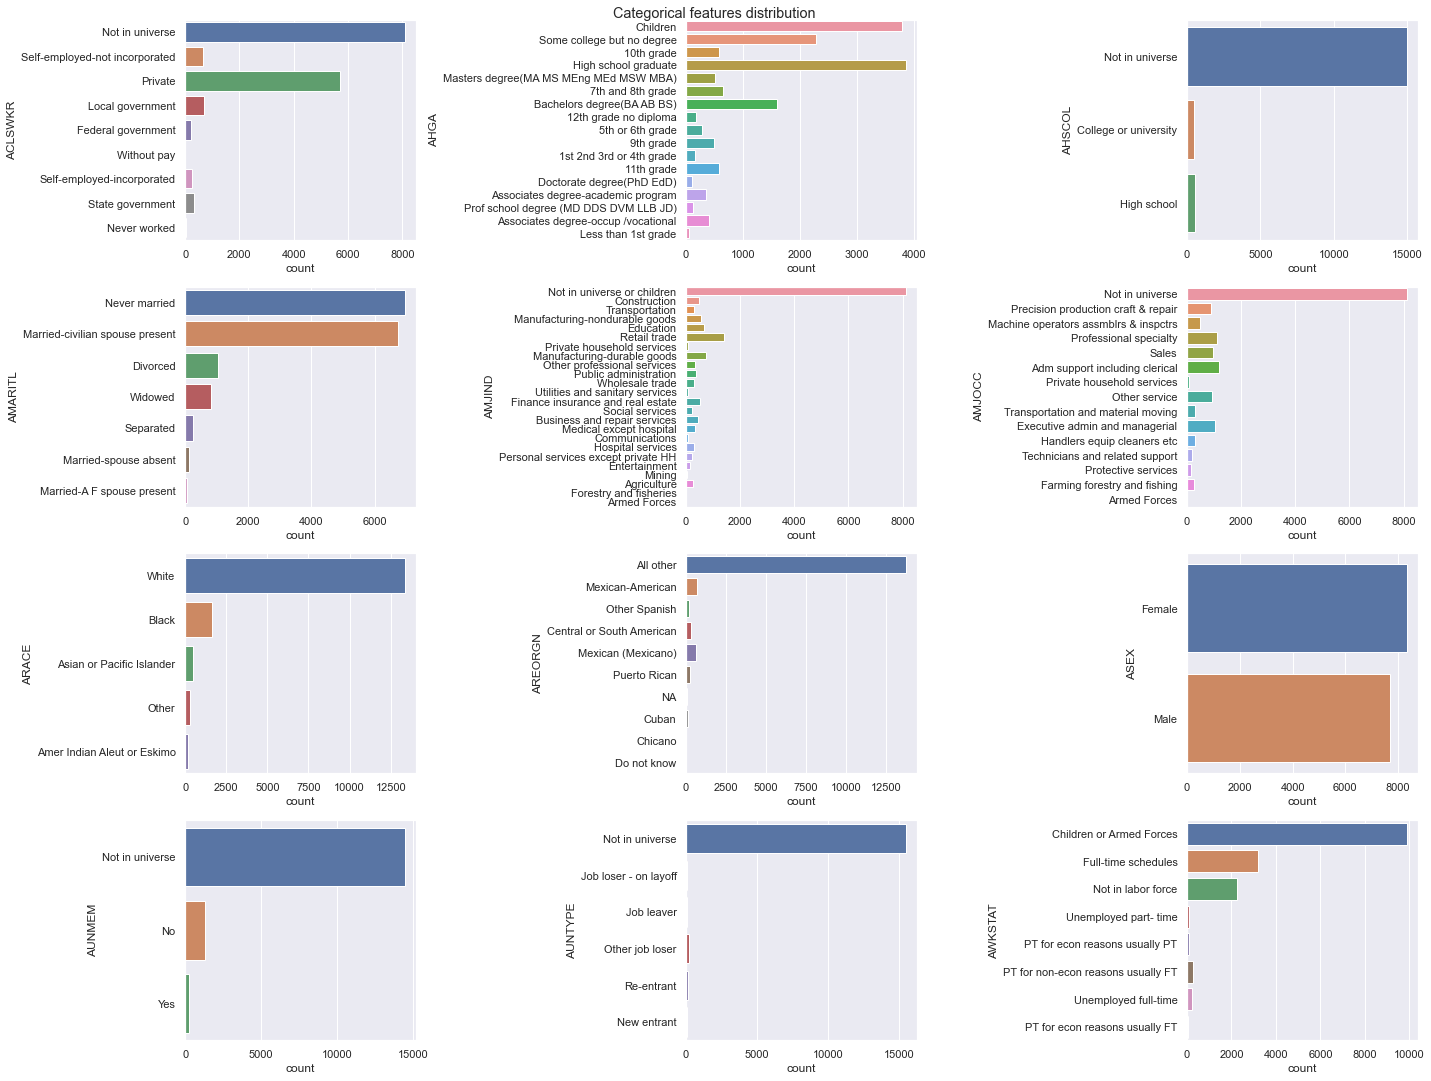

In [14]:
# Plot numerical features distribuiton
fig, ax = plt.subplots(figsize=(20,15), ncols=3, nrows=4)
ax = ax.flatten()

for ax_i, col in zip(ax, cat_fs):
    g = sns.countplot(y=X_train[col], ax=ax_i)
    
fig.tight_layout()

plt.suptitle('Categorical features distribution', y=1)
plt.show()

First of all, features 'AHSCOL', 'AUNTYPE' and 'AREORGN' are not informative at all, most of values there are 'Not in universe', so we can just remove them.

In [15]:
cols_to_remove = ['AHSCOL', 'AUNTYPE','AREORGN'] #, 'AMJIND']
hlp.remove_features(cols_to_remove, [X_train, X_val, test])
for col in cols_to_remove:
    cat_fs.remove(col)

C:\Anaconda3\envs\ds37\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Secondly, some features are too diversity, while this devirsification is not informative due to the fact that some classes are poorly presented. So, we are going to merge some classes for 'AWKSTAT', 'AMJOCC', 'AHGA', 'ACLSWKR' based on common sence. The merging scheme is represented below in the dicts, while it will be applied during preprocessing pipeline.

In [16]:
# AWKSTAT
employment_map = {'PT for econ reasons usually FT':'PT',
 'PT for econ reasons usually PT': 'PT',
 'PT for non-econ reasons usually FT':'PT',
 'Unemployed full-time':'Unemployed',
 'Unemployed part- time':'Unemployed'
}

In [17]:
# AMJOCC
occupation_map = dict(
    zip([
        'Private household services', 'Transportation and material moving',
        'Farming forestry and fishing', 'Technicians and related support',
        'Handlers equip cleaners etc', 'Protective services',
        'Armed Forces'
    ], ['Other service'] * 7))

In [18]:
# AHGA
degree_map = {
    'Less than 1st grade': '1-6',
    '1st 2nd 3rd or 4th grade': '1-6',
    '5th or 6th grade': '1-6',
    'Prof school degree (MD DDS DVM LLB JD)': 'Prof school or doc',
    'Doctorate degree(PhD EdD)': 'Prof school or doc',
    '9th grade': '9-12',
    '10th grade': '9-12',
    '11th grade': '9-12',
    '12th grade no diploma': '9-12',
}

In [19]:
# ACLSWKR
class_map = {
    'Local government': 'Government',
    'Federal government': 'Government',
    'State government': 'Government',
    'Self-employed-incorporated': 'Self-employed',
    'Self-employed-not incorporated': 'Self-employed',
    'Never worked': 'Other',
    'Without pay': 'Other'
}

Based on the unique values that a feature have we can choose encoding strategy. <br>
Feature AHGA is ordinal, so we can encode it as a sorted range. <br>
Features AHSCOL, ASEX, AUNMEM, MIGSAME, MIGSUN and VETQVA are almost binary (they have Yes/No/NA values), so we can encode them as binary+NA. <br>
All other features are categorical, so we will use one-hot-encoding for them.

In [20]:
# Devide categorical features into binay, ordinal and other
binary_cat = ['ASEX', 'AUNMEM', 'MIGSAME', 'MIGSUN', 'VETQVA']
ordinal_cat = ['AHGA']
other_cat = list(set(cat_fs).difference(set(binary_cat+ordinal_cat)))
assert len(binary_cat) + len(ordinal_cat) + len(other_cat) == len(cat_fs)

## Numerical features

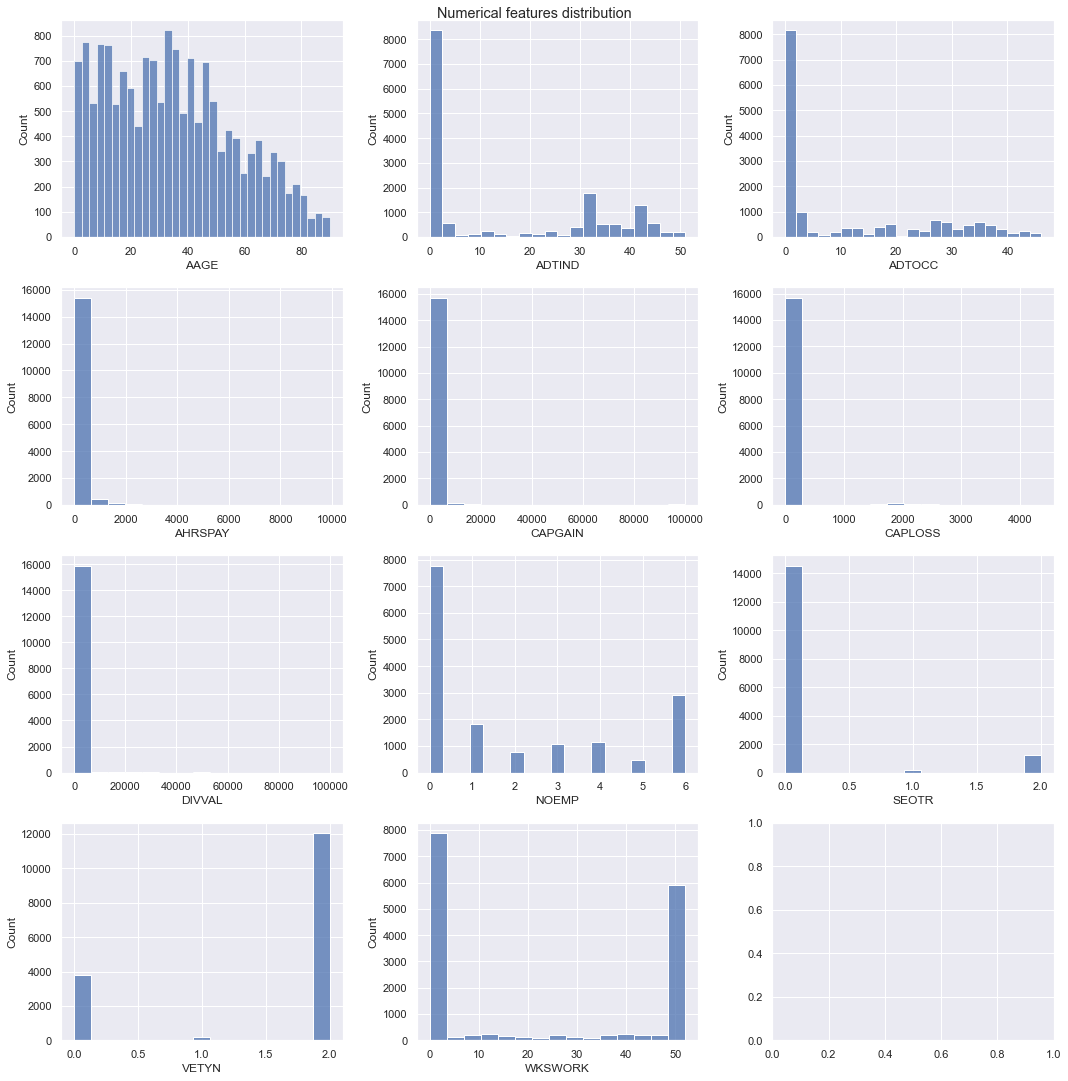

In [21]:
# Plot numerical features distribuiton
fig, ax = plt.subplots(figsize=(15,15), ncols=3, nrows=4)
ax = ax.flatten()

for ax_i, col in zip(ax, num_fs):
    sns.histplot(X_train[col], ax=ax_i)
    
fig.tight_layout()

plt.suptitle('Numerical features distribution', y=1)
plt.show()

We again can see that features 'AHRSPAY', 'CAPGAIN', 'CAPLOSS', 'DIVVAL' are not informative at all, however know we are not going to just drop them, but use PCA.

In [22]:
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_train[num_fs].copy())

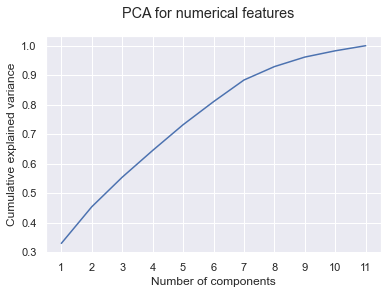

In [23]:
pca = PCA().fit(X_num_scaled)

sns.lineplot(y = np.cumsum(pca.explained_variance_ratio_), x = range(1,12))
plt.xticks(range(1, 12))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.suptitle('PCA for numerical features')
plt.show()

This curve quantifies how much of the total, 11-dimensional variance is contained within the first N components. For our case we can say that 7 components describe about 90% of the variance. However, based on this chart we can say that PCA-decomposition is not effective, because we can reduce only 4 dimensions out of 11, so we are not going to use it further.

# 2 Data preprocessing

Based on the data exploration step the following preprocessing plan was created:
    - Categorical columns:
        - impute empty values if any
        - encode 'AHGA' as ordinal
        - encode 'AHSCOL', 'ASEX', 'AUNMEM', 'MIGSAME', 'MIGSUN', 'VETQVA' as binary
        - encode all others with OHE
        
    - Numerical columns:
        - fill empty values
        - scale data (standardize)
        - apply PCA for 7 components

In [24]:
# Devide data into features and target.
y_test = test['target'].copy()
X_test = test.drop('target', axis=1).copy()
del test

In [25]:
cols_merge_cats = ['AWKSTAT', 'AMJOCC', 'ACLSWKR']
categories_merger = dict(
    zip(cols_merge_cats,
        [employment_map, occupation_map, class_map]))

In [26]:
ordinal_codes = {
    'AHGA': {
        'Children': 0,
        '1-6': 1,
        '7th and 8th grade': 2,
        '9-12': 3,
        'High school graduate': 4,
        'Some college but no degree': 5,
        'Associates degree-occup /vocational': 6,
        'Associates degree-academic program': 7,
        'Bachelors degree(BA AB BS)': 8,
        'Masters degree(MA MS MEng MEd MSW MBA)': 9,
        'Prof school or doc': 10,
    }
}

In [27]:
na_values = ['Not in universe under 1 year old', 'Not in universe']

In [28]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    #('pca', PCA(7))
])

cat_binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values = '?', strategy='most_frequent')),
    ('pandarizer',FunctionTransformer(lambda x: pd.DataFrame(x, columns = binary_cat))),
    ('bin_enc', hlp.BinaryEncoder(na_values))
])

cat_ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values = '?', strategy='most_frequent')),
    ('pandarizer',FunctionTransformer(lambda x: pd.DataFrame(x, columns = ordinal_cat))),
    ('merger', hlp.CustomEncoder({'AHGA':degree_map})),
    ('ord_enc', hlp.CustomEncoder(ordinal_codes))
])

cat_other_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values = '?', strategy='most_frequent')),
    ('pandarizer', FunctionTransformer(lambda x: pd.DataFrame(x, columns = other_cat))),
    ('merger', hlp.CustomEncoder(categories_merger)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, num_fs),
        ('categorical_binary', cat_binary_transformer, binary_cat),
        ('categorical_ordinal', cat_ordinal_transformer, ordinal_cat),
        ('categorical_other', cat_other_transformer, other_cat)])

In [29]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['AAGE', 'ADTIND', 'ADTOCC', 'AHRSPAY',
                                  'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'NOEMP',
                                  'SEOTR', 'VETYN', 'WKSWORK']),
                                ('categorical_binary',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(missing_values='?',
                                                                strategy='most_frequent')),
                                                 ('pand...
                                                                                     'PT for econ reasons usually PT': 'PT',
                                                                                     'PT for non-econ reasons usually FT': 'PT',
                                                                                     'Unemployed full-time': 'Unemployed',
                                                                                     'Unemployed part- time': 'Unemployed'}})),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['AMJIND', 'HHDFMX', 'AWKSTAT', 'ACLSWKR',
                                  'PENATVTY', 'GRINST', 'ARACE', 'PARENT',
                                  'HHDREL', 'AMJOCC', 'FILESTAT', 'PEMNTVTY',
                                  'AMARITL', 'PEFNTVTY', 'PRCITSHP',
                                  'GRINREG'])])

In [30]:
X_train_fitted = preprocessor.transform(X_train)
X_val_fitted = preprocessor.transform(X_val)
X_test_fitted = preprocessor.transform(X_test)

In [31]:
print(f'Train size: {X_train_fitted.shape} \nValidation size: {X_val_fitted.shape} \nTest size: {X_test_fitted.shape}')

Train size: (16000, 307) 
Validation size: (4000, 307) 
Test size: (10000, 307)


In [32]:
# Get columns names after OHE
cat_other_ohe_cols = preprocessor.named_transformers_['categorical_other']['ohe'].get_feature_names().tolist()
# Collect all new preprocessed columns names into one list
#fitted_columns = ['pca_'+str(i) for i in range(1,8)] + binary_cat + ordinal_cat + cat_other_ohe_cols
fitted_columns = num_fs + binary_cat + ordinal_cat + cat_other_ohe_cols
# Replace symbols that can't be in column name
fitted_columns = [x.replace('<','st').replace(' ','_') for x in fitted_columns]

In [33]:
assert len(fitted_columns) == X_train_fitted.shape[1], 'Something is wrong with number of fitted columns or their names'

In [34]:
# Transform data from numpies to dataframes with the column names we have just created
X_train_fitted = pd.DataFrame(X_train_fitted, columns = fitted_columns).astype(float)
X_val_fitted = pd.DataFrame(X_val_fitted, columns = fitted_columns).astype(float)
X_test_fitted = pd.DataFrame(X_test_fitted, columns = fitted_columns).astype(float)

Also we create another version of transformations, it is very basic, we just impute empty values, scale numeric featues and do OHE for categorical ones.

In [35]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values = '?', strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor_base = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, num_fs),
        ('categorical', cat_transformer, cat_fs)
    ])

preprocessor_base.fit(X_train)

X_train_fitted_base = preprocessor_base.transform(X_train)
X_val_fitted_base = preprocessor_base.transform(X_val)
X_test_fitted_base = preprocessor_base.transform(X_test)

Now let's choose the preprocessing pipeline based on its performance on metrics. We are going to train LightGBM model because we have very sparse data due to the OHE and LightGBM operates an exclusive feature bundling technique to improve time on sparse data. 

In [36]:
# Baseline preprocessing to compare with
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train_fitted_base, y_train)
y_pred = lgbm_clf.predict(X_val_fitted_base)
hlp.compute_metrics(y_val, y_pred, [' - 50000.', ' 50000+.'], ' 50000+.')

,result
Balanced_Accuracy,0.708
MCC,0.528


In [37]:
y_pred = lgbm_clf.predict(X_train_fitted_base)
hlp.compute_metrics(y_train, y_pred, [' - 50000.', ' 50000+.'], ' 50000+.')

,result
Balanced_Accuracy,0.840
MCC,0.785


In [38]:
# Custom preprocessing
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train_fitted, y_train)
y_pred = lgbm_clf.predict(X_val_fitted)
hlp.compute_confusion_matrix(y_val, y_pred, [' - 50000.', ' 50000+.'], ' 50000+.')

,y > 50.000,y < 50.000
a(x) > 50.000,105,49
a(x) < 50.000,140,3706


In [39]:
hlp.compute_metrics(y_val, y_pred, [' - 50000.', ' 50000+.'], ' 50000+.')

,result
Balanced_Accuracy,0.708
MCC,0.518


In [40]:
y_pred = lgbm_clf.predict(X_train_fitted)
hlp.compute_metrics(y_train, y_pred, [' - 50000.', ' 50000+.'], ' 50000+.')

,result
Balanced_Accuracy,0.841
MCC,0.782


Interesting that the base preprocessing works a little better than the custom one. So the further modelling is going to be done on he data that is preprocessed with the base transformations.

# 3 Model training

## Imbalance

Taking into account that our sample is not so big to do some undersampling, we are going to use oversampling technique for imbalance improvement. The SMOTE technique logic is the following: First some random example from minority class is chosen. Then its neighbours are found(like in KNN). After that, synthetic example is created for a randomly selected point between the a randomly selected neighbor the original random example.

We are not going to fight the class disbalance sever to still be able to predict the validation and test samples.

In [41]:
# Use SMOTE techinque for oversampling the minority class
smote = SMOTE(sampling_strategy=0.4, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_fitted, y_train)
hlp.get_resample_results(y_train, y_train_smote)

,%_orig,%_fitted,count_orig,count_fitted
<50.000,0.94,0.71,15022,15022
>50.000,0.06,0.29,978,6008


We can see that after SMOTE transformation the minority class grew up from 6% to 17%. That's exactly what we wanted - to adjust the minority class just a little.

In [42]:
# Fit model for the oversampled data
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train_smote, y_train_smote)
y_pred = lgbm_clf.predict(X_val_fitted)
print('Metrics on validation:')
hlp.compute_metrics(y_val, y_pred, [' - 50000.', ' 50000+.'], ' 50000+.')

Metrics on validation:


,result
Balanced_Accuracy,0.768
MCC,0.598


In [43]:
y_pred = lgbm_clf.predict(X_train_fitted)
print('Metrics on train:')
hlp.compute_metrics(y_train, y_pred, [' - 50000.', ' 50000+.'], ' 50000+.')

Metrics on train:


,result
Balanced_Accuracy,0.831
MCC,0.722


We can see some overfitting of the model because the metrics are 12-35 higher for train compared to validation datasets. So we are going to add regularization during grid search model fitting. Also we will eliminate features based on feature importance.

## Modelling 

### LGBM

We are going to tune hyperparameters to improve model quality and reduce overfitting. We will add regularization, limit trees depth, increase leaf size, try Gradient-based One-Side Sampling, add featuring subsampling and try sample subsampling.

In [44]:
parameters = {
    'min_child_samples': [20, 30],
    'max_depth': [3, 5, 20],
    'learning_rate': [0.1, 0.3],
    'boosting_type': ['gbdt', 'goss'],
    'subsample': [0.4, 1],
    'class_weight': [{0:0.5, 1:0.5}, {0:0.3, 1:0.7}],

}
lgbm_clf = LGBMClassifier(reg_alpha=1, reg_lambda=1, colsample_bytree =0.8, random_state =42)
lgbm_clf_cv = GridSearchCV(lgbm_clf, parameters, scoring='balanced_accuracy')

In [45]:
y_train_replaced = y_train_smote.replace({" - 50000.":0, ' 50000+.':1})

In [46]:
%%time
lgbm_clf_cv.fit(X_train_smote, y_train_replaced)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Wall time: 6min 40s


GridSearchCV(estimator=LGBMClassifier(colsample_bytree=0.8, random_state=42,
                                      reg_alpha=1, reg_lambda=1),
             param_grid={'boosting_type': ['gbdt', 'goss'],
                         'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.3, 1: 0.7}],
                         'learning_rate': [0.1, 0.3], 'max_depth': [3, 5, 20],
                         'min_child_samples': [20, 30], 'subsample': [0.4, 1]},
             scoring='balanced_accuracy')

In [47]:
lgbm_clf_cv.best_estimator_

LGBMClassifier(class_weight={0: 0.3, 1: 0.7}, colsample_bytree=0.8, max_depth=5,
               random_state=42, reg_alpha=1, reg_lambda=1, subsample=0.4)

In [48]:
LGBMClassifier(boosting_type='goss', class_weight={0: 0.3, 1: 0.7},
               colsample_bytree=0.8, max_depth=5, min_data_in_leaf=20,
               random_state=42, reg_alpha=1, reg_lambda=1, subsample=0.4)

LGBMClassifier(boosting_type='goss', class_weight={0: 0.3, 1: 0.7},
               colsample_bytree=0.8, max_depth=5, min_data_in_leaf=20,
               random_state=42, reg_alpha=1, reg_lambda=1, subsample=0.4)

In [49]:
# Predict train, validation and test with the best etimator
lgbm_prediction_train = lgbm_clf_cv.best_estimator_.predict(X_train_fitted)
lgbm_prediction_val = lgbm_clf_cv.best_estimator_.predict(X_val_fitted)
lgbm_prediction_test = lgbm_clf_cv.best_estimator_.predict(X_test_fitted)

In [50]:
# Also predict probabilities of classes. We will need them during stacking
lgbm_pred_prob_train = lgbm_clf_cv.best_estimator_.predict_proba(X_train_fitted)[:,1]
lgbm_pred_prob_val = lgbm_clf_cv.best_estimator_.predict_proba(X_val_fitted)[:,1]
lgbm_pred_prob_test = lgbm_clf_cv.best_estimator_.predict_proba(X_test_fitted)[:,1]

In [51]:
y_pred_train = pd.Series(lgbm_prediction_train).replace({0:" - 50000.", 1:' 50000+.'})
print('Metrics on train:')
hlp.compute_metrics(y_train, y_pred_train, [' - 50000.', ' 50000+.'], ' 50000+.')

Metrics on train:


,result
Balanced_Accuracy,0.852
MCC,0.594


In [52]:
y_pred_val = pd.Series(lgbm_prediction_val).replace({0:" - 50000.", 1:' 50000+.'})
print('Metrics on validation:')
hlp.compute_metrics(y_val, y_pred_val, [' - 50000.', ' 50000+.'], ' 50000+.')

Metrics on validation:


,result
Balanced_Accuracy,0.830
MCC,0.541


That is good, we fought overfitting. Also we can see that the balanced accuracy that we used as scoring has increased heavily. So we can say that we have a good model.

In [53]:
hlp.compute_confusion_matrix(y_val, y_pred_val, [' - 50000.', ' 50000+.'], ' 50000+.')

,y > 50.000,y < 50.000
a(x) > 50.000,175,203
a(x) < 50.000,70,3552


Based on the confusion matrix we can observe the increase in 50k+ class recall (if compare to the previous model based without tuning params).

### RF

In [54]:
parameters = {
    'min_samples_split': [5, 8],
    'max_depth': [3, 5, 20],
    'min_impurity_decrease': [0.1, 0.3],
    'criterion': ['gini', 'entropy'],
    'class_weight': [{0: 0.5,1: 0.5}, {0: 0.3, 1: 0.7}]
}

rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf_cv = GridSearchCV(rf_clf, parameters, scoring='balanced_accuracy')

In [55]:
y_train_replaced = y_train_smote.replace({" - 50000.":0, ' 50000+.':1})

In [56]:
%%time
rf_clf_cv.fit(X_train_smote, y_train_replaced)

Wall time: 3min 53s


GridSearchCV(estimator=RandomForestClassifier(n_estimators=200,
                                              random_state=42),
             param_grid={'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.3, 1: 0.7}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 20],
                         'min_impurity_decrease': [0.1, 0.3],
                         'min_samples_split': [5, 8]},
             scoring='balanced_accuracy')

In [57]:
rf_clf_cv.best_estimator_

RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, criterion='entropy',
                       max_depth=3, min_impurity_decrease=0.1,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [58]:
RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, criterion='entropy',
                       max_depth=3, min_impurity_decrease=0.1,
                       min_samples_split=5, n_estimators=200, random_state=42)

RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, criterion='entropy',
                       max_depth=3, min_impurity_decrease=0.1,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [59]:
# Predict train, validation and test with the best etimator
rf_prediction_train = rf_clf_cv.best_estimator_.predict(X_train_fitted)
rf_prediction_val = rf_clf_cv.best_estimator_.predict(X_val_fitted)
rf_prediction_test = rf_clf_cv.best_estimator_.predict(X_test_fitted)

In [60]:
# Also predict probabilities of classes. We will need them during stacking
rf_pred_prob_train = rf_clf_cv.best_estimator_.predict_proba(X_train_fitted)[:,1]
rf_pred_prob_val = rf_clf_cv.best_estimator_.predict_proba(X_val_fitted)[:,1]
rf_pred_prob_test = rf_clf_cv.best_estimator_.predict_proba(X_test_fitted)[:,1]

In [61]:
y_pred_train = pd.Series(rf_prediction_train).replace({0:" - 50000.", 1:' 50000+.'})
print('Metrics on train:')
hlp.compute_metrics(y_train, y_pred_train, [' - 50000.', ' 50000+.'], ' 50000+.')

Metrics on train:


,result
Balanced_Accuracy,0.815
MCC,0.322


In [62]:
y_pred_val = pd.Series(rf_prediction_val).replace({0:" - 50000.", 1:' 50000+.'})
print('Metrics on validation:')
hlp.compute_metrics(y_val, y_pred_val, [' - 50000.', ' 50000+.'], ' 50000+.')

Metrics on validation:


,result
Balanced_Accuracy,0.811
MCC,0.318


This model is also does not overfit, however we see dramatical decrease in MCC metric. Why is this so? Let's try to find out the answer based on the confusion matrix.

In [63]:
hlp.compute_confusion_matrix(y_val, y_pred_val, [' - 50000.', ' 50000+.'], ' 50000+.')

,y > 50.000,y < 50.000
a(x) > 50.000,223,1081
a(x) < 50.000,22,2674


Ok, so it is obvious now that despite the fact the minority class recall increased, it decreased heavily for the majority class. That is an interesting result, models differ a lot, so let's try to build a very simple blend of them.

## Tune ensemble weights

In this section we are going to find out the best weights for model combination. Then we will use the found weights to build a model blend.

In [64]:
from itertools import combinations_with_replacement

In [65]:
y_val_blend = pd.DataFrame([lgbm_pred_prob_val, rf_pred_prob_val]).T
y_val_blend.columns = ['LGBM', 'RF']
y_val_blend.head()

,LGBM,RF
0,0.014,0.468
1,0.010,0.318
2,0.049,0.334
3,0.003,0.344
4,0.005,0.419


In [66]:
# Choose all possible combinations of 0-1 weights that sum up to 1
all_pos = list(combinations_with_replacement(np.linspace(0, 1, 101), 2))
all_pos = [x for x in all_pos if sum(x) == 1]
all_pos[:5]

[(0.0, 1.0), (0.01, 0.99), (0.02, 0.98), (0.03, 0.97), (0.04, 0.96)]

In [67]:
y_val_replaced = y_val.replace({" - 50000.":0, ' 50000+.':1})
y_test_replaced = y_test.replace({" - 50000.":0, ' 50000+.':1})

In [68]:
results = []
for i in all_pos:
    # Choose 1 weights combination, sum them and say it is 1 of sum>=0.5 or 0 vice versa
    bas = hlp.balanced_accuracy_score(y_val_replaced, y_val_blend.mul(i).sum(axis=1).round())
    results.append(bas)

In [69]:
max(results)

0.8629392103046278

In [70]:
best_weights_idx = results.index(max(results))
best_weights_idx

39

In [71]:
all_pos[best_weights_idx]

(0.39, 0.61)

## Get results on test

In [72]:
y_test_blend = pd.DataFrame([lgbm_pred_prob_test, rf_pred_prob_test]).T
y_test_blend.columns = ['LGBM', 'RF']
y_test_blend.head()

,LGBM,RF
0,0.007,0.274
1,0.549,0.557
2,0.030,0.486
3,0.001,0.175
4,0.158,0.616


In [73]:
final_prediction = y_test_blend.mul(all_pos[best_weights_idx]).sum(axis=1).round()

In [74]:
hlp.compute_confusion_matrix(y_test_replaced, final_prediction, [0, 1], 1)

,y > 50.000,y < 50.000
a(x) > 50.000,472,641
a(x) < 50.000,155,8732


In [75]:
hlp.compute_metrics(y_test_replaced, lgbm_prediction_test, [0, 1], 1)

,result
Balanced_Accuracy,0.814
MCC,0.529


# 4 Summary

**Feature importance**

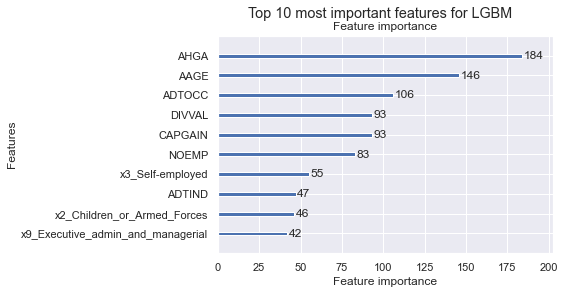

In [76]:
plot_importance(lgbm_clf_cv.best_estimator_, max_num_features=10)
plt.suptitle('Top 10 most important features for LGBM')
plt.show()

In [77]:
fi_rf = dict(zip(X_train_fitted.columns, rf_clf_cv.best_estimator_.feature_importances_))
fi_rf = dict(sorted(fi_rf.items(), key=lambda item: item[1]))

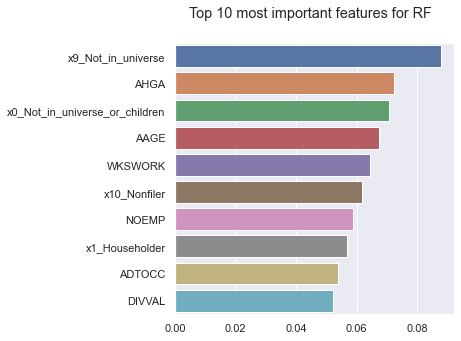

In [78]:
plt.figure(figsize=(5,5))

sns.barplot(y=list(fi_rf.keys())[-10:][::-1], x=list(fi_rf.values())[-10:][::-1])

plt.suptitle('Top 10 most important features for RF')
plt.show()

Based on the feature importance charts for both models we can say that age, education and num persons worked for employer are important for both models. Interesting that such obvious features as capital gain and occupation code are important for LGBM, while we can't see them in RF top 10. All in all, LGBM top 10 features are quite obvious and simple and even expected.

**Summary**

During this project, we found out that some of the categorical features consisted mostly of trash and removed them. Also some other categorical features had too many categories with just a few observations inside, so we merged some categories. Also, we fulfilled empty values with the most frequent ones(there was just a few of them). Also, we tried PCA and found out that it is not helpful for the observed dataset. Moreover, the data was highly imbalanced 94/6 so we used SMOTE algorithm to balance train data up to 70/30 ratio.<br>
The most important features are education, sex and age which is expected.<br>
Finally we found out that random forest and boosting are almost equal (58% and 42% respectfully) in the stacked model prediction. Our final balanced accuracy score on test is 81% and MCC is 53%.